In [ ]:
#Primary analysis workflow for tissue-based XYZseq experiments
#demo data: 20181124_DSP_2

In [103]:
#import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

import scanpy.api as sc

In [104]:
#designate working directory 
#path should contain: matrix.mtx, plate_map.csv, cell_annotate.txt
#for scanpy annotations: barcodes.tsv, genes.tsv
#
#

path="./data/"

#get and format the data

array_columns=['gene','cell','count']

count_matrix=pd.read_csv(path + 'matrix.mtx', sep=' ', header=None, index_col=None, skiprows=3, names=array_columns)

#check the format of the data
count_matrix.head()

,gene,cell,count
0,36239,1,1
1,73978,1,1
2,93211,1,1
3,41563,1,8
4,36413,1,2


number of UMIs total: 653265
number of cells: 1877


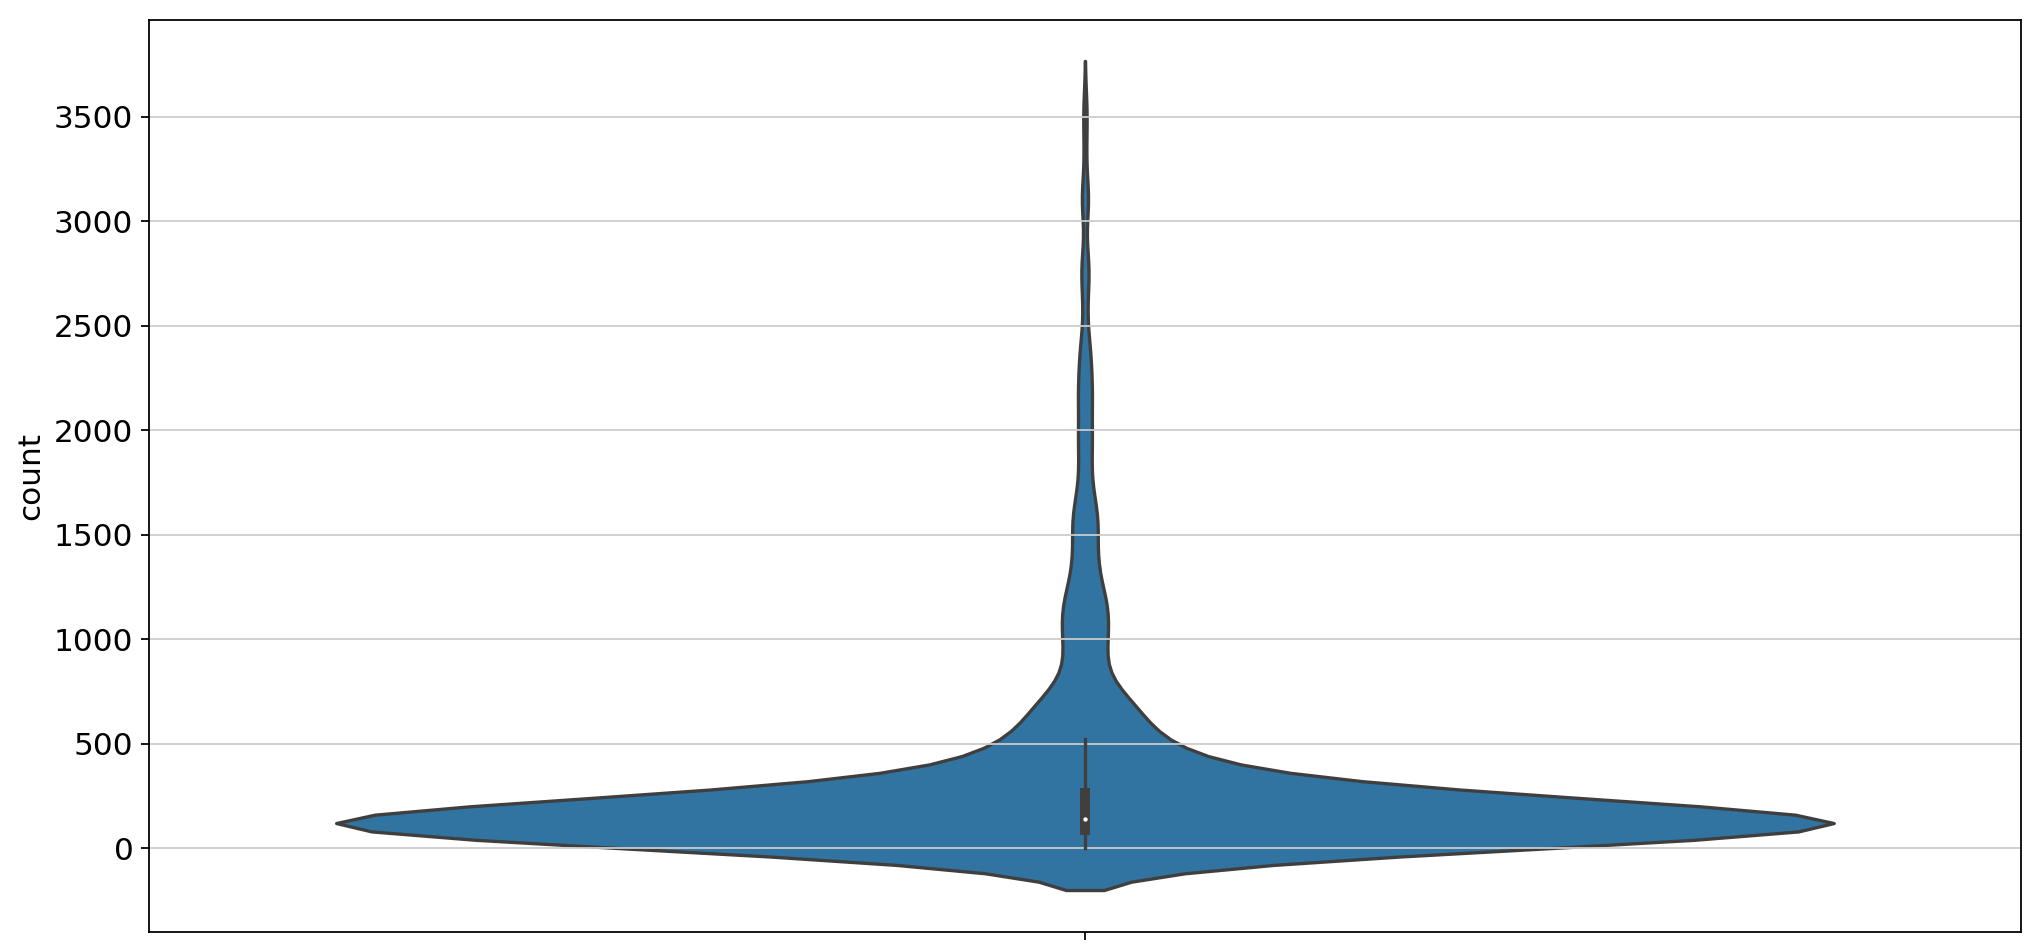

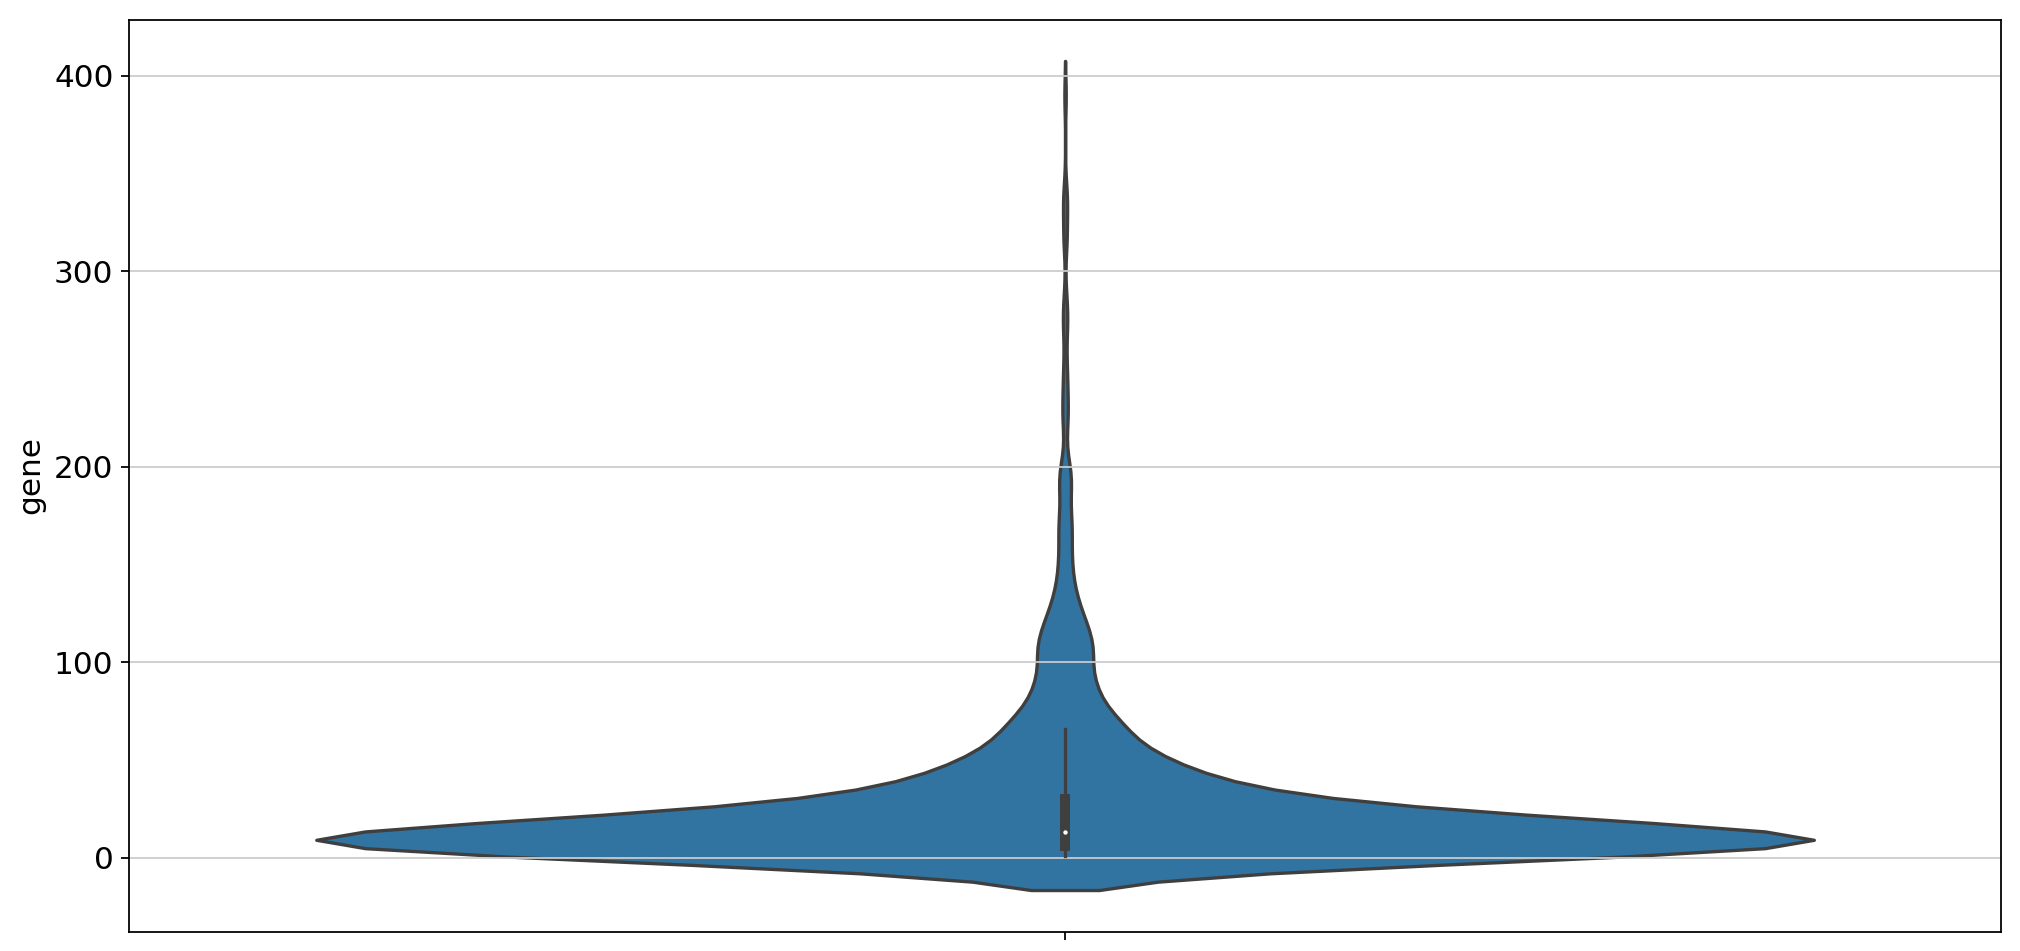

In [105]:
##show some metrics for the data 

total_UMIS=count_matrix['count'].sum()
cell_number=count_matrix['cell'].nunique()


print("number of UMIs total:", total_UMIS)
print("number of cells:", cell_number)


#cell number, median UMIs and genes per cell, top genes



#UMIs per cell
UMIs=count_matrix.groupby('cell')['count'].sum()

q=UMIs.quantile(0.99)
UMIs=UMIs[UMIs < q]

sns.violinplot(UMIs, orient='v')
plt.show()

#genes per cell
genes=count_matrix.groupby('cell')['gene'].nunique()
sns.violinplot(genes, orient='v')
plt.show()


#%mito

#over abbundant genes

In [112]:
##organize data for spatial plotting

#annotate the count matrix with barcodes
cell_annotation_columns=['barcode','cell']

annot=pd.read_csv(path +'cell_annotate.txt', header=None, names=cell_annotation_columns)
annot['barcode']=annot['barcode'].str[4:]


count_matrix_annotated=count_matrix.merge(annot, on='cell',how='left')
count_matrix_annotated=count_matrix_annotated.groupby('barcode')['count'].sum().reset_index()


#get the barocode map
map_columns=['barcode', 'X', 'Y']
spatial_map=pd.read_csv(path +'plate23_map.csv', header=None, names=map_columns)

map_array=spatial_map.merge(count_matrix_annotated, on='barcode', how='left')

map_array.to_csv('map_array.csv')


##define the hexagon plotting function


def hexagon(x, y, c='k'):
    #figrue out X offset
    points = [[x + 0.665, y],
              [x + 0.3325, y + 0.5],
              [x - 0.3325, y + 0.5],
              [x - 0.665, y],
              [x - 0.3325, y - 0.5],
              [x + 0.3325, y - 0.5]]
    
    polygon = plt.Polygon(points, edgecolor='w', fc=c)
    plt.gca().add_patch(polygon)




map_array=map_array.fillna('0')
map_array['count']=map_array['count'].astype(int)


#log transform
map_array['count']=np.log(map_array['count']+1)

#match colors to counts
max_val=max(map_array['count'])

norm = mpl.colors.Normalize(vmin=0,vmax=max_val)

count_hex=[]

#set threshold 6.124 = 500UMIs

for i in map_array['count']:
    if i > 5.6:
        count_hex.append(mpl.colors.rgb2hex(cm.hot(norm(i))[:3]))
    else:
        count_hex.append('#000000')

map_array['color']=count_hex




In [113]:
plt.rcParams['figure.figsize'] = [15, 7.5]

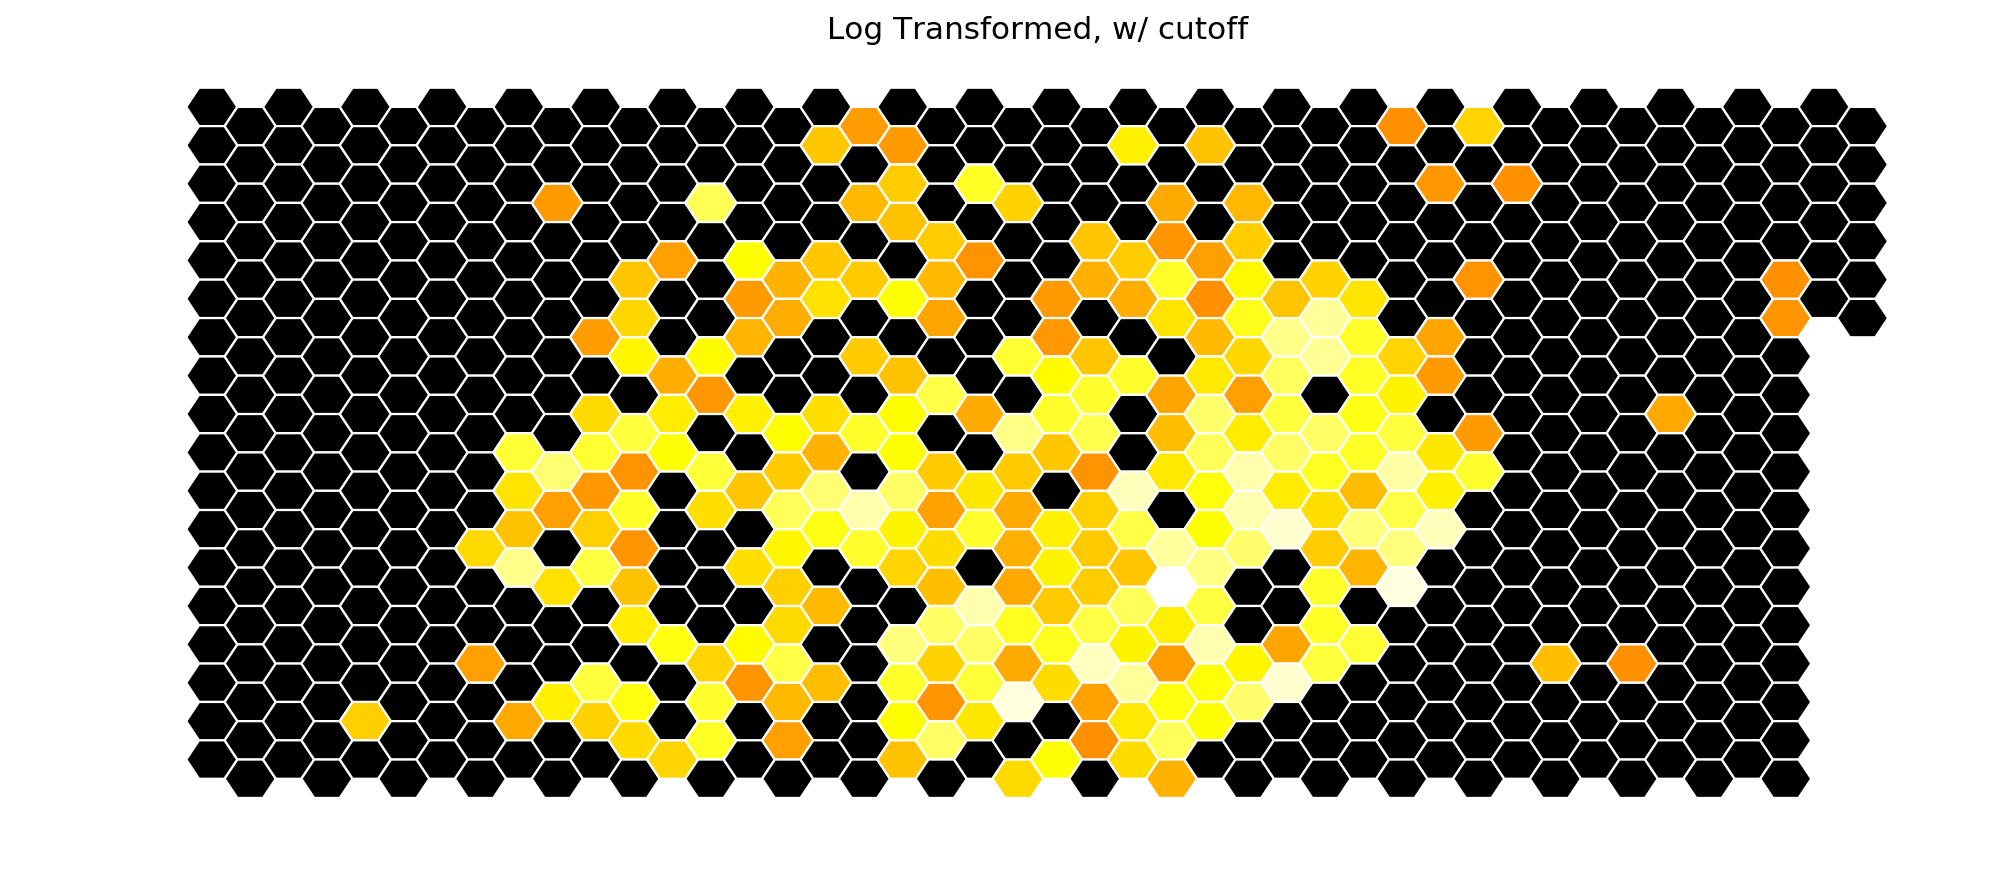

In [111]:
##plot the spatial array

for index, row in map_array.iterrows():
    if row['X'] % 2 != 0:
        row['Y']=row['Y']-0.5
    
    hexagon(row['X'],row['Y'],row['color'])

    
plt.ylim(18,0) #flip y axis
plt.axis('scaled')
plt.title('Log Transformed, w/ cutoff')
plt.axis('off')

plt.show()



In [ ]:

#call tissue wells and get metrtics for bulk data per spatial coordinate
#call cells with associated well barcode indices

#UMIs per spatial barcode

#genes per spatial barcode



In [65]:
##scanpy tsne UMAP

sc.settings.verbosity=3
sc.settings.set_figure_params(dpi=80)
sc.logging.print_versions()
results_file = './write/results.h5ad'

#sc.settings = True

adata=sc.read(path + 'matrix.mtx', cache=True).T

#adata.obs_names=pd.read_csv(path + 'barcodes.tsv', header=None, sep='\t')

#adata.obs_names=pd.read_csv(path + 'barcodes.tsv', header=None)


scanpy==1.3.2 anndata==0.6.11 numpy==1.14.6 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.0 statsmodels==0.9.0 
... reading from cache file ./cache/data-matrix.h5ad


In [66]:
sc.pp.filter_cells(adata, min_genes=10) 
sc.pp.filter_genes(adata, min_cells=3)

#mito_genes=[name for name in adata.var_names if name.startswith('MT-')]

#adata.obs['percent'] = np.sum(
 #   adata[:, mito_genes].X, axis=1).Al / np.sum(adata.X, axis=1).Al

adata.obs['n_counts'] = adata.X.sum(axis=1)

filtered out 761 cells that have less than 10 genes expressed
filtered out 103815 genes that are detected in less than 3 cells


In [114]:
#sc.pl.violin(adata, ['n_counts', 'n_genes'], jitter=0.4, multi_panel=True)

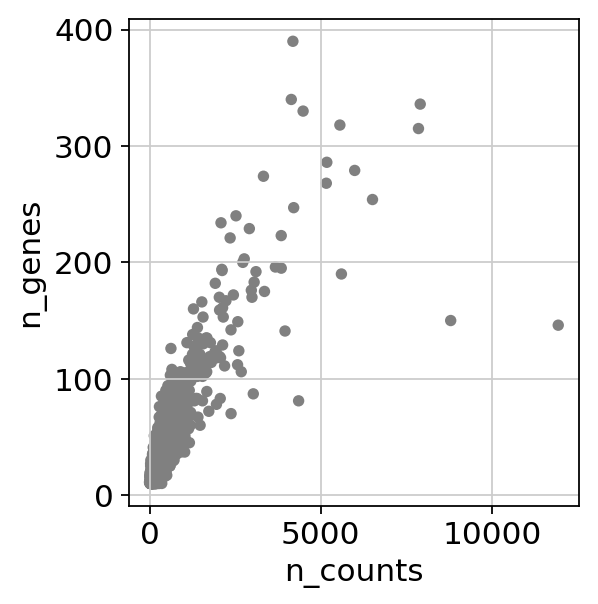

In [68]:
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [69]:
adata

AnnData object with n_obs × n_vars = 1140 × 2943 
    obs: 'n_genes', 'n_counts'
    var: 'n_cells'

In [70]:
adata.raw = sc.pp.log1p(adata, copy=True)

In [71]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

filtered out 1 cells that have less than 1 counts


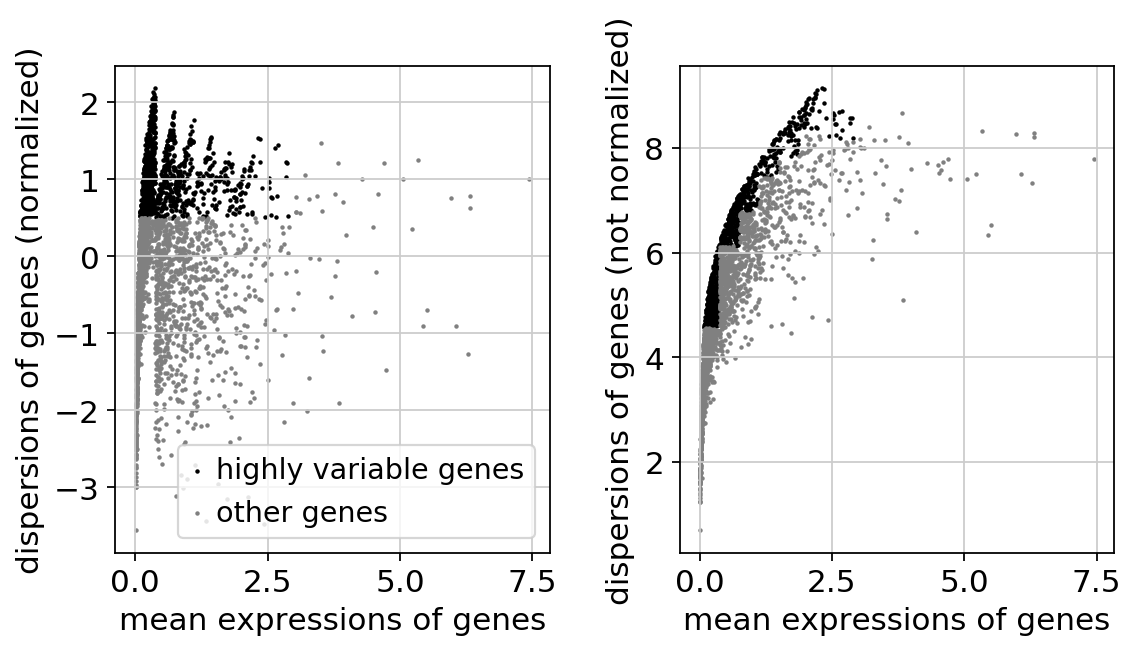

In [72]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [73]:
adata = adata[:, filter_result.gene_subset]

In [74]:
sc.pp.log1p(adata)

In [75]:
sc.pp.regress_out(adata, ['n_counts'])

regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:01.93)


In [76]:
sc.pp.scale(adata, max_value=10)

In [77]:
adata.write(results_file)

In [78]:
sc.tl.pca(adata, svd_solver='arpack')

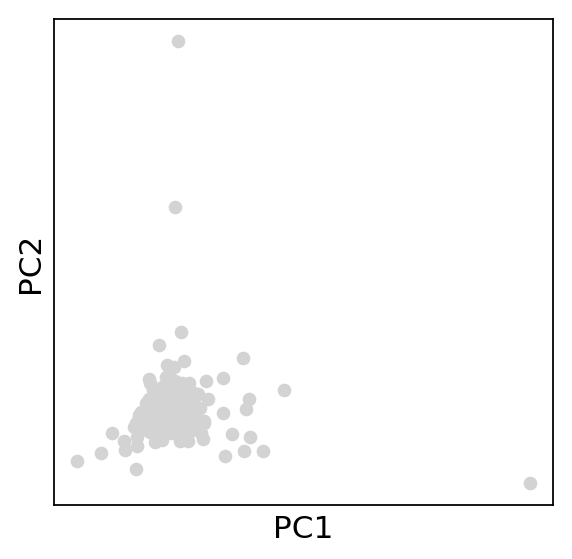

In [79]:
sc.pl.pca(adata)

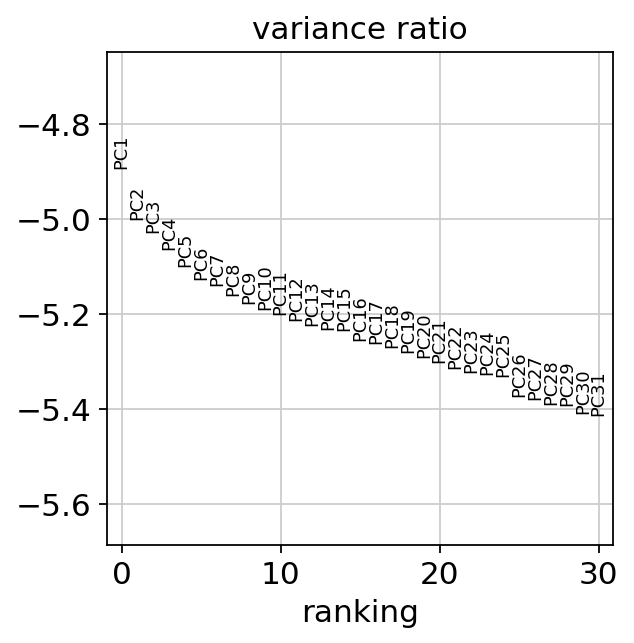

In [80]:
sc.pl.pca_variance_ratio(adata, log=True)

In [81]:
adata.write(results_file)

In [82]:
adata = sc.read(results_file)

In [83]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00.22) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [84]:
 sc.tl.tsne(adata)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:07.86) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


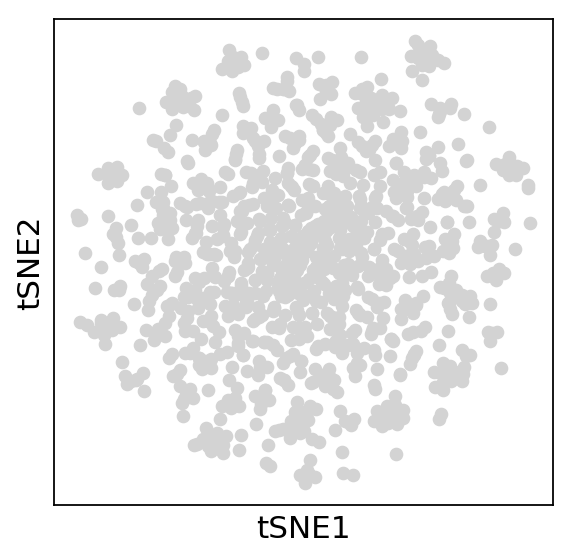

In [85]:
sc.pl.tsne(adata)

In [86]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:01.44) --> added
    'X_umap', UMAP coordinates (adata.obsm)


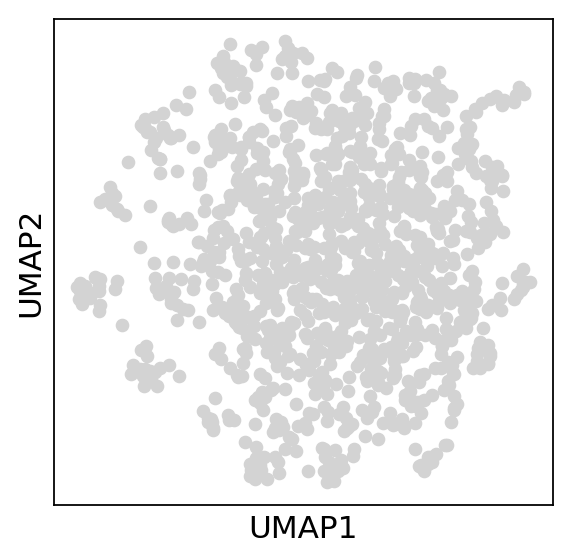

In [87]:
sc.pl.umap(adata)